In [1]:
from torchtext.vocab import vocab
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from torchtext.data import metrics 
import string
import glob
import math
import pickle
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torchvision.models
import torchvision.datasets
from torchvision import transforms
from PIL import Image
from google.colab import drive
from collections import Counter

In [2]:
drive.mount('/content/gdrive')
caption_path = "/content/gdrive/My Drive/CSC413/Flickr8k/captions.txt"
image_path = "/content/gdrive/My Drive/CSC413/Flickr8k/Images/"
image_names = glob.glob(image_path + '*.jpg')

Mounted at /content/gdrive


In [3]:
"""
Read file containing all the dataset's captions and return a dict where the keys 
are image names and values are lists of 5 captions(5 per image).
"""
def load_captions(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()

    map = {}
    for line in text.split("\n")[1:-1]: # Ignore last empty line
        tokens = line.split(".jpg,")
        image_id, image_desc = tokens[0], tokens[1]

        image_desc = image_desc.lower() # Lower case all words
        image_desc = [c for c in image_desc if c.isalpha() or c == ' '] # Remove all symbols
        image_desc = ''.join(image_desc)
        image_desc = image_desc.strip()
        image_desc = "<bos> " + image_desc + " <eos>" # Add <bos> and <eos> to each caption

        if image_id not in map:
            map[image_id] = []
        map[image_id].append(image_desc)
    return map


"""
Counts the number of occurrences of each unique word and store it in a dict
return the frequency dict a vocab object which contains a stoi and itos look up dict.
"""
def word_dict(captions):
    counter = {}
    for lst in captions.values():
        for cap in lst:
            words = cap.split()
            for word in words:
                if word not in counter:
                    counter[word] = 0
                counter[word] += 1
    # Add padding token for batch training
    counter['<pad>'] = 1 
    return counter, vocab(counter)

In [4]:
"""
A transformation applied to an image to pad it into a square with black pixels
"""
class SquarePad:
    def __call__(self, image):
        s = image.size
        max_dim = max(s)
        min_dim = min(s)

        pad1 = (max_dim - min_dim) // 2
        pad2 = (max_dim - min_dim) - pad1

        if s[0] == max_dim:
            return transforms.functional.pad(image,[0,pad1,0,pad2],0)
        else:
            return transforms.functional.pad(image,[pad1,0,pad2,0],0)


"""
Load all images in the dataset and put them together with their corresponding captions.

Preprocess the images into 224 x 224 and turn the captions into indices of the words.
If use_pad is True, images will be padded into squares, if use_pad is False, images
will be cropped into squares.

Split the dataset into 6000 training, 1000 validation, 1091 testing
"""
def build_datasets(Vocab, image_names, captions_dict, use_pad):
    if use_pad:
        preprocess = transforms.Compose([      
            SquarePad(),                   # Pad the smaller dimension equally on both sides with black pixels
            transforms.Resize(224),        # Scale down to 224 x 224
            transforms.ToTensor()
        ])
    else:
        preprocess = transforms.Compose([
            transforms.Resize(224),       # Scale down so that the smaller dimension is 224
            transforms.CenterCrop(224),   # Crop out 224 x 224, centered in the larger dimension
            transforms.ToTensor(),
        ])

    data = []
    for image_name in image_names:
        img = Image.open(image_name)

        img_tensor = preprocess(img)
        image_id = image_name[48:].split(".jpg")[0]
        captions = captions_dict[image_id]
        stoi = Vocab.get_stoi()

        inds = []

        for caption in captions:
            tokens = caption.split()
            inds.append([stoi[word] for word in tokens])

        data.append([img_tensor, inds])
    return data[0: 6000], data[6000: 7000], data[7000:]

In [5]:
# Load captions
captions_dict = load_captions(caption_path)

# Create word dicts
freq, Vocab = word_dict(captions_dict)

# Construct train, validation and test datasets
train_data, val_data, test_data = build_datasets(Vocab, image_names, captions_dict, use_pad=False)

In [6]:
# Print some statistics about the data

# Max caption length
# Min caption length
# Average caption length
# Vocab size
# 10 most frequent words
# 10 least frequent words

# Find max, min, avg caption length
max_cap_len, min_cap_len = 0, float('inf')
total_cap_len = 0

for img in captions_dict:
    caps = captions_dict[img]
 
    for cap in caps:
        cur_len = len(cap.split())-2 # Not counting <bos> <eos>
        total_cap_len += cur_len
        if cur_len > max_cap_len:
            max_cap_len = cur_len
            longest_caption = cap
        if cur_len < min_cap_len:
            min_cap_len = cur_len
            shortest_caption = cap

avg_cap_len = total_cap_len/(8091*5)

print('Highest caption length: ' + str(max_cap_len))
print('Longest caption: ' + longest_caption)
print('Lowest caption length: ' + str(min_cap_len))
print('Shortest caption: ' + shortest_caption)
print('Average caption length: ' + str(avg_cap_len))
print('Vocabulary size: ' + str(len(Vocab.get_itos())))

word_counter = Counter(freq)
most_common = [pair[0] for pair in word_counter.most_common(12)]
most_common.remove('<bos>')
most_common.remove('<eos>')
print('10 most common words: ' + str(most_common))
least_common = [pair[0] for pair in word_counter.most_common()[-11:]]
least_common.remove('<pad>')
print('10 least common words: ' + str(least_common))
print('Index of <bos>: ' + str(Vocab.get_stoi()['<bos>']))
print('Index of <eos>: ' + str(Vocab.get_stoi()['<eos>']))
print('Index of <pad>: ' + str(Vocab.get_stoi()['<pad>']))

Highest caption length: 35
Longest caption: <bos> an africanamerican man wearing a green sweatshirt and blue vest is holding up  dollar bills in front of his face  while standing on a busy sidewalk in front of a group of men playing instruments <eos>
Lowest caption length: 1
Shortest caption: <bos> a <eos>
Average caption length: 10.785761957730813
Vocabulary size: 8781
10 most common words: ['a', 'in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of']
10 least common words: ['swatting', 'containig', 'rainstorm', 'breezeway', 'cocker', 'spaniels', 'weight', 'majestically', 'scrolled', 'patterns']
Index of <bos>: 0
Index of <eos>: 15
Index of <pad>: 8780


In [7]:
"""
Takes in a dataset, runs the image tensors through a pretrained CNN model to extract the features
and reconstructs the dataset with the images replaced by flattened feature tensors (49*512)
"""
def extract_features(model, data):
    new_data = []
    N = len(data)

    i = 0
    while True:
        batch = data[i: min(i + 100, N)].copy()  # Process the images in batches of 100
        img_batch = []

        # Construct a tensor of the images in a batch
        for img, _ in batch:
            img_batch.append(img)
        img_batch = torch.stack(img_batch)

        # Calculate the feature maps
        with torch.no_grad():
            data_features = model(img_batch).detach()
            data_features = data_features.reshape((-1, 512, 49)).permute(0, 2, 1).detach()
        
        # Reconstruct the dataset
        for j in range(len(batch)):
            new_data.append([data_features[j], batch[j][1]])

        if i + 100 >= N:
            break
        else:
            i += 100
        print(len(new_data)) # Print progress
    return new_data

In [ ]:
# Use VGG16 as the feature extractor, remove the fully connected classifier in the end
vgg16 = nn.Sequential(*list(torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True).children())[:-1])
vgg16.eval()

train_data_features = extract_features(vgg16, train_data)

val_data_features = extract_features(vgg16, val_data)

test_data_features = extract_features(vgg16, test_data)


In [ ]:
# Save the extracted features to disk
torch.save(train_data_features, '/content/gdrive/My Drive/CSC413/train_data_features')
torch.save(val_data_features, '/content/gdrive/My Drive/CSC413/val_data_features')
torch.save(test_data_features, '/content/gdrive/My Drive/CSC413/test_data_features')

In [8]:
# Load the extracted features from disk
train_data_features = torch.load('/content/gdrive/My Drive/CSC413/train_data_features')
val_data_features = torch.load('/content/gdrive/My Drive/CSC413/val_data_features')
test_data_features = torch.load('/content/gdrive/My Drive/CSC413/test_data_features')

In [9]:
"""
Add positional encoding to a tensor that will be used as input to the transformer

The math of positional encoding is here 
    https://kazemnejad.com/blog/transformer_architecture_positional_encoding/

This class is adapted from 
    https://towardsdatascience.com/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
"""
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:, :token_embedding.size(1), :])


"""
The caption generator model

Takes in extracted features from an image and a target caption for teacher forcing,
outputs a generated caption.
"""
class CaptionGenerator(nn.Module):
    def __init__(self, vocab_size):
        super(CaptionGenerator, self).__init__()

        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=64) # Embed target caption to dense vector of size 64
        self.src_embed2 = nn.Linear(256, 64) # Linear layers to embed image features to size 64
        self.src_embed = nn.Linear(512, 256)
        
        self.positional_encoder = PositionalEncoding(dim_model=64, dropout_p=0.1, max_len=100) # Positional encoder for the transformer
        self.trans = torch.nn.Transformer(batch_first = True, num_encoder_layers=1, num_decoder_layers=1, d_model=64, dim_feedforward=512)
        
        self.linear = nn.Linear(64, vocab_size) # Projection layer to get final word distributions
        self.batch_norm1 = nn.BatchNorm1d(num_features=64)
        self.batch_norm2 = nn.BatchNorm1d(num_features=64)

            
    def forward(self, features, tgt, tgt_mask, tgt_key_padding_mask=None):
        # features: N x 49 x 512
        # tgt: N x max_batch_cap_len

        # Embed input feature map into size 64
        src = self.src_embed(features)
        src = torch.relu(src)
        src = self.src_embed2(src)
        src = self.batch_norm1(src.permute(0, 2, 1)).permute(0, 2, 1)
        src = torch.relu(src)

        # Embed target caption into size 64
        tgt = self.embed(tgt)
        tgt = self.batch_norm2(tgt.permute(0, 2, 1)).permute(0, 2, 1)
        tgt = torch.relu(tgt)

        # Feed image embedding as encoder input and caption embedding as decoder input
        # to the transformer
        tgt = self.positional_encoder(tgt)
        out = self.trans(src=src, tgt=tgt, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        
        # Output the N x max_batch_cap_len x vocab_size final word distribution logits
        return self.linear(out)


    # Mask out padding tokens in the target caption to let the transformer ignore them
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        return (matrix == pad_token)

In [10]:
"""
collate function given to the data loader

Takes in a sublist of data of the form [[image_tensor, [cap1, cap2, cap3, cap4, cap5]], ...]

Return two tensors: 
    xs in the format [image1, image1, image1, image1, image1, ...]
    ys in the format [padded_cap1, padded_cap2, padded_cap3, padded_cap4, padded_cap5, ...]

All captions are padded to the maximum caption length in the batch + 1
"""
def pad_collate(batch):
    # find the longest caption of the batch
    max_len = 0
    for _, caps in batch:
        for cap in caps:
            max_len = max(max_len, len(cap))

    # pad every caption to max_len + 1
    xs, ys = [], []
    for img, caps in batch:
        for cap in caps:
            xs.append(img)
            ys.append(cap + [8780 for _ in range(max_len - len(cap) + 1)])
    
    xs = torch.stack(xs)
    ys = torch.LongTensor(ys)
    return xs, ys
      

"""
Main training loop
"""
def train(model, train_data, valid_data, batch_size, num_epochs, lr, Vocab):
    checkpoint_path = '/content/gdrive/My Drive/CSC413/project/ckpt-{}.pk'

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Loss is calculated per token and per caption, if the token is the index of <pad>, loss is 0
    criterion = nn.CrossEntropyLoss(ignore_index=8780, reduction='none')

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

    pad_ind = Vocab.get_stoi()['<pad>']
    
    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]
    n = 0

    for i in range(num_epochs):
        for imgs, batch_caps in train_loader:            
            N = imgs.shape[0]//5          # Number of images in this batch
            # Input for the transformer should be shifted right by 1 and include the <bos>
            y_input = batch_caps[:,:-1]

            # Expected output should not include <bos>
            y_expected = batch_caps[:,1:] 

            # Upper triangular matrix to mask out future tokens in the target caption
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(y_input.shape[1])

            model.train()
            pred = model(imgs, y_input, tgt_mask, model.create_pad_mask(y_input, pad_ind))


            loss = criterion(pred.permute(0, 2, 1), y_expected) # 5N * max_batch_caplen
            loss = loss.sum(dim=1)                              # Sum up the loss per item in the batch, across the sequence length
            cap_lens = (y_expected != 8780).sum(dim=1)          # The true length of each caption without padding
            loss = loss/cap_lens                                # Average loss over the tokens
            loss = loss.reshape((N, 5)).min(dim=1)[0].mean()    # Loss per image is the minimum loss with the 5 captions, then averaged over images in the batch
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            losses.append(float(loss)) # Batch average loss
            if (n + 1) % 10 == 0:
                print(str(n + 1) + ': ' + str(losses[n])) # Print batch loss every 10 batches
            iters.append(n)
            n += 1

        # After each epoch, compute training accuracy
        iters_sub.append(n)
        train_acc = get_accuracy(model, train_data, Vocab)
        train_accs.append(train_acc)
        print('\nTrain acc finished')

        # Compute validation accuracy
        val_acc = get_accuracy(model, valid_data, Vocab)
        val_accs.append(val_acc)
        print('val acc finished')
        print("Iter %d. [Val bleu %.0f%%] [Train bleu %.0f%%] [Loss %.5f]\n" % (
                n, val_acc * 100, train_acc * 100, losses[n-1]))

        # Save model weights at the end of each epoch
        torch.save(model.state_dict(), checkpoint_path.format(i))

    make_plot(iters, losses, iters_sub, train_accs, val_accs) # Plot training curve


"""
Make two plots:
    batch loss over iterations (minibatch)
    training and validation accuracy over epochs
"""
def make_plot(iters, losses, iters_sub, train_accs, val_accs):
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


"""
Given the feature map of an image and a max length, generate a caption.
Return a list of word indices.
"""
def predict(model, img, BOS_token, EOS_token, max_length=37):
    model.eval() # Inference mode
    
    y_input = torch.tensor([[BOS_token]], dtype=torch.long) # Start with <bos>

    # Generate at most max_length tokens
    for _ in range(max_length):
        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(y_input.shape[1])
        
        pred = model(img.unsqueeze(0), y_input, tgt_mask) # 1*batch cap len *8781
        
        pred = torch.argmax(pred, dim=2) # Deterministic output, always choose the word with highest score
        
        y_input = torch.tensor([[BOS_token] + [ind for ind in pred[0]]], dtype=torch.long) # Output sequence will be fed back into input

        # Stop if model predicts end of sentence
        if y_input[0][-1] == EOS_token:
            break

    return y_input.view(-1).tolist()


"""
Calculate the accuracy of given model on data.
Accuracy is measured as BLEU score (between 0 and 1)
"""
def get_accuracy(model, data, Vocab):
    model.eval() # Inference mode

    stoi = Vocab.get_stoi()
    BOS_token = stoi['<bos>']
    EOS_token = stoi['<eos>']
    PAD_token = stoi['<pad>']
    specials = [EOS_token, BOS_token, PAD_token] # Remove all special tokens
    itos = Vocab.get_itos()

    acc = 0
    with torch.no_grad():
        for img, captions in data:
            pred = predict(model, img, BOS_token, EOS_token)

            # Candidate corpus is the model's prediction
            candidate_corpus = [[itos[ind] for ind in pred if ind not in specials]]

            # References corpus is the list of 5 captions
            references_corpus = [[[itos[ind] for ind in caption if ind not in specials] 
                                    for caption in captions]]

            # 0.25*bleu1 + 0.25*bleu2 + 0.25*bleu3 + 0.25*bleu4, max bleu score among the 5 captions
            bleu_score = metrics.bleu_score(candidate_corpus, references_corpus)
            acc += bleu_score
    # Return avarage bleu score of the entire data
    return acc/len(data)


"""
Print a caption given a list of word indices and a vocab object.
"""
def print_pred(pred, Vocab):
    itos = Vocab.get_itos()
    print(' '.join([itos[ind] for ind in pred]))

10: 7.186161518096924
20: 5.6485419273376465
30: 4.76673698425293
40: 4.578329086303711
50: 4.221673011779785
60: 3.952779531478882
70: 3.975400447845459
80: 3.835310220718384
90: 3.6968677043914795
100: 3.495593547821045

Train acc finished
val acc finished
Iter 100. [Val bleu 4%] [Train train 3%] [Loss 3.49559]

110: 3.4846088886260986
120: 3.4164412021636963
130: 3.3598830699920654
140: 3.2897698879241943
150: 3.2803776264190674
160: 3.490534543991089
170: 3.1693115234375
180: 3.256640911102295
190: 3.1951420307159424
200: 3.1145355701446533

Train acc finished
val acc finished
Iter 200. [Val bleu 4%] [Train train 4%] [Loss 3.11454]

210: 2.9738974571228027
220: 2.868018388748169
230: 3.130070209503174
240: 2.849332571029663
250: 3.0390777587890625
260: 3.082289218902588
270: 2.9018430709838867
280: 3.042682409286499
290: 2.7646372318267822
300: 2.8278634548187256

Train acc finished
val acc finished
Iter 300. [Val bleu 5%] [Train train 5%] [Loss 2.82786]

310: 2.8063976764678955
32

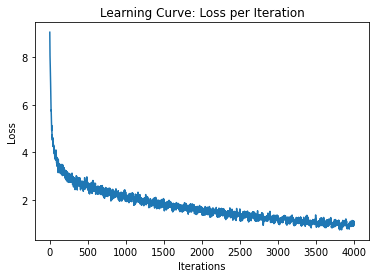

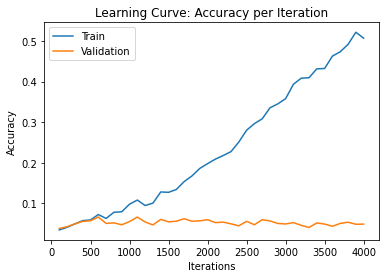

In [ ]:
model3 = CaptionGenerator(8781)
train(model3, train_data_features, val_data_features, 60, 40, 0.002, Vocab)

In [ ]:
model3.load_state_dict(torch.load('/content/gdrive/My Drive/CSC413/project/ckpt-10.pk'))

<All keys matched successfully>

In [19]:
model4 = CaptionGenerator(8781)
model4.load_state_dict(torch.load('/content/gdrive/My Drive/CSC413/project/ckpt-39.pk'))

<All keys matched successfully>

In [30]:
"""
Given a model, a set of raw data and extracted features and an index i,
Print the model's generated caption for the ith image, then print the 5 target
captions. Then print the image.
"""
def show_img_and_pred(model, i, raw_data, data_features):
    plt.imshow(raw_data[i][0].permute(1, 2, 0))
    print_pred(predict(model, data_features[i][0], 0, 15), Vocab)
    print()
    for cap in data_features[i][1]:
        print_pred(cap, Vocab)


<bos> a man with a mohawk is standing on the street <eos>

<bos> a man in yellow grimaces <eos>
<bos> a man wearing a yellow shirt with a dramatic look on his face <eos>
<bos> the man in the yellow tshirt is pulling a large grin on his face <eos>
<bos> there is a man wearing a yellow shirt and grimacing <eos>
<bos> this man is smiling very big at the camera <eos>


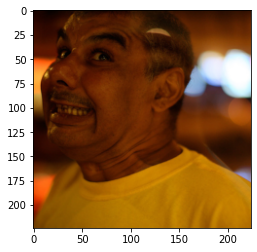

In [31]:
show_img_and_pred(model4, 78, test_data, test_data_features)

In [32]:
"""
The caption generator model

Takes in extracted features from an image and a target caption for teacher forcing,
outputs a generated caption.
"""
class SimpleCaptionGenerator(nn.Module):
    def __init__(self, vocab_size):
        super(SimpleCaptionGenerator, self).__init__()


        self.embed_shared = nn.Linear(512, 100)
        self.embed1 = nn.Linear(4900, 1000)
        self.embed2 = nn.Linear(1000, 1000)
        self.embed3 = nn.Linear(1000, 256)

        self.word_embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=100)
        self.rnn = nn.GRU(input_size=100, hidden_size=256, batch_first=True)

        # a fully-connect layer that outputs a distribution over
        # the next token, given the RNN output
        self.proj = nn.Linear(in_features=256, out_features=vocab_size)
        

        self.batch_norm1 = nn.BatchNorm1d(num_features=100)
        self.batch_norm2 = nn.BatchNorm1d(num_features=1000)
        self.batch_norm3 = nn.BatchNorm1d(num_features=1000)
        self.batch_norm4 = nn.BatchNorm1d(num_features=256)
        self.batch_norm5 = nn.BatchNorm1d(num_features=100)

            
    def forward(self, features, tgt):
        # features: N x 49 x 512
        # tgt: N x max_batch_cap_len

        # Embed input feature map into size 64, used as initial hidden unit of GRU
        img_emb = self.embed_shared(features)
        img_emb = self.batch_norm1(img_emb.permute(0, 2, 1)).permute(0, 2, 1)
        img_emb = torch.relu(img_emb)
        img_emb = img_emb.reshape((-1, 4900))
        img_emb = self.embed1(img_emb)
        img_emb = self.batch_norm2(img_emb)
        img_emb = torch.relu(img_emb)
        img_emb = self.embed2(img_emb)
        img_emb = self.batch_norm3(img_emb)
        img_emb = torch.relu(img_emb)
        img_emb = self.embed3(img_emb)
        img_emb = self.batch_norm4(img_emb)
        img_emb = torch.relu(img_emb)

        # Embed target caption into size 100, used as teacher forcing input for GRU
        word_emb = self.word_embed(tgt)
        word_emb = self.batch_norm5(word_emb.permute(0, 2, 1)).permute(0, 2, 1)
        word_emb = torch.relu(word_emb)

        out, hidden = self.rnn(word_emb, img_emb.unsqueeze(0))
        out = self.proj(out)
        
        # Output the N x max_batch_cap_len x vocab_size final word distribution logits
        return out, hidden

In [15]:
"""
Slightly modified training function for SimpleCaptionGenerator
"""
def train1(model, train_data, valid_data, batch_size, num_epochs, lr, Vocab):
    checkpoint_path = '/content/gdrive/My Drive/CSC413/project/ckpt1-{}.pk'

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Loss is calculated per token and per caption, if the token is the index of <pad>, loss is 0
    criterion = nn.CrossEntropyLoss(ignore_index=8780, reduction='none')

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

    pad_ind = Vocab.get_stoi()['<pad>']
    
    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]
    n = 0

    for i in range(num_epochs):
        for imgs, batch_caps in train_loader:            
            N = imgs.shape[0]//5          # Number of images in this batch
            # Input for the transformer should be shifted right by 1 and include the <bos>
            y_input = batch_caps[:,:-1]

            # Expected output should not include <bos>
            y_expected = batch_caps[:,1:] 

            model.train()
            pred, _ = model(imgs, y_input)


            loss = criterion(pred.permute(0, 2, 1), y_expected) # 5N * max_batch_caplen
            loss = loss.sum(dim=1)                              # Sum up the loss per item in the batch, across the sequence length
            cap_lens = (y_expected != 8780).sum(dim=1)          # The true length of each caption without padding
            loss = loss/cap_lens                                # Average loss over the tokens
            loss = loss.reshape((N, 5)).min(dim=1)[0].mean()    # Loss per image is the minimum loss with the 5 captions, then averaged over images in the batch
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            losses.append(float(loss)) # Batch average loss
            if (n + 1) % 10 == 0:
                print(str(n + 1) + ': ' + str(losses[n])) # Print batch loss every 10 batches
            iters.append(n)
            n += 1

        # After each epoch, compute training accuracy
        iters_sub.append(n)
        train_acc = get_accuracy1(model, train_data, Vocab)
        train_accs.append(train_acc)
        print('\nTrain acc finished')

        # Compute validation accuracy
        val_acc = get_accuracy1(model, valid_data, Vocab)
        val_accs.append(val_acc)
        print('val acc finished')
        print("Iter %d. [Val bleu %.0f%%] [Train bleu %.0f%%] [Loss %.5f]\n" % (
                n, val_acc * 100, train_acc * 100, losses[n-1]))

        # Save model weights at the end of each epoch
        torch.save(model.state_dict(), checkpoint_path.format(i))

    make_plot(iters, losses, iters_sub, train_accs, val_accs) # Plot training curve

In [13]:
"""
Given the feature map of an image and a max length, generate a caption.
Return a list of word indices.
"""
def predict1(model, img, BOS_token, EOS_token, max_length=37):
    model.eval() # Inference mode
    
    y_input = torch.tensor([[BOS_token]], dtype=torch.long) # Start with <bos>

    # Generate at most max_length tokens
    for _ in range(max_length):        
        pred, hidden = model(img.unsqueeze(0), y_input) # 1*batch cap len *8781
        
        pred = torch.argmax(pred, dim=2) # Deterministic output, always choose the word with highest score
        
        y_input = torch.tensor([[BOS_token] + [ind for ind in pred[0]]], dtype=torch.long) # Output sequence will be fed back into input

        # Stop if model predicts end of sentence
        if y_input[0][-1] == EOS_token:
            break

    return y_input.view(-1).tolist()


"""
Calculate the accuracy of given model on data.
Accuracy is measured as BLEU score (between 0 and 1)
"""
def get_accuracy1(model, data, Vocab):
    model.eval() # Inference mode

    stoi = Vocab.get_stoi()
    BOS_token = stoi['<bos>']
    EOS_token = stoi['<eos>']
    PAD_token = stoi['<pad>']
    specials = [EOS_token, BOS_token, PAD_token] # Remove all special tokens
    itos = Vocab.get_itos()

    acc = 0
    with torch.no_grad():
        for img, captions in data:
            pred = predict1(model, img, BOS_token, EOS_token)

            # Candidate corpus is the model's prediction
            candidate_corpus = [[itos[ind] for ind in pred if ind not in specials]]

            # References corpus is the list of 5 captions
            references_corpus = [[[itos[ind] for ind in caption if ind not in specials] 
                                    for caption in captions]]

            # 0.25*bleu1 + 0.25*bleu2 + 0.25*bleu3 + 0.25*bleu4, max bleu score among the 5 captions
            bleu_score = metrics.bleu_score(candidate_corpus, references_corpus)
            acc += bleu_score
    # Return avarage bleu score of the entire data
    return acc/len(data)

10: 5.108496189117432
20: 4.637971878051758
30: 4.476635932922363
40: 4.477704048156738
50: 4.254778861999512
60: 4.031646251678467
70: 3.820178508758545
80: 3.8558990955352783
90: 3.54441237449646
100: 3.5483269691467285

Train acc finished
val acc finished
Iter 100. [Val bleu 3%] [Train bleu 3%] [Loss 3.54833]

110: 3.2297654151916504
120: 3.375074625015259
130: 3.2799863815307617
140: 3.2388341426849365
150: 2.979865550994873
160: 2.8022654056549072
170: 2.9418983459472656
180: 2.929373025894165
190: 2.9144973754882812
200: 2.998628854751587

Train acc finished
val acc finished
Iter 200. [Val bleu 4%] [Train bleu 5%] [Loss 2.99863]

210: 2.7536966800689697
220: 2.6599862575531006
230: 2.8958277702331543
240: 2.8538408279418945
250: 2.7238945960998535
260: 2.6183645725250244
270: 2.743516206741333
280: 2.722364664077759
290: 2.7147250175476074
300: 2.721947431564331

Train acc finished
val acc finished
Iter 300. [Val bleu 5%] [Train bleu 7%] [Loss 2.72195]

310: 2.5451607704162598
32

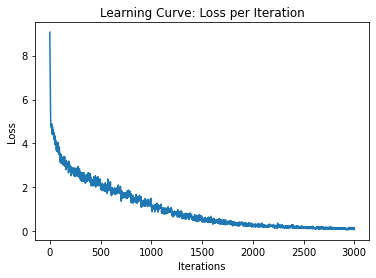

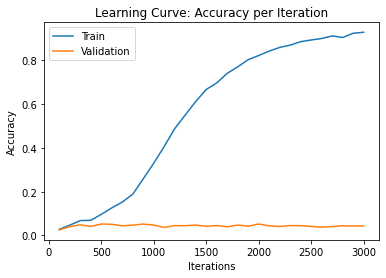

In [17]:
m = SimpleCaptionGenerator(8781)
train1(m, train_data_features, val_data_features, 60, 30, 0.002, Vocab)

<bos> a person sit on a bench in front of a wooden bench <eos>

<bos> a couple of people sit outdoors at a table with an umbrella and talk <eos>
<bos> three people are sitting at an outside picnic bench with an umbrella <eos>
<bos> three people sit at an outdoor cafe <eos>
<bos> three people sit at an outdoor table in front of a building painted like the union jack <eos>
<bos> three people sit at a picnic table outside of a building painted like a union jack <eos>


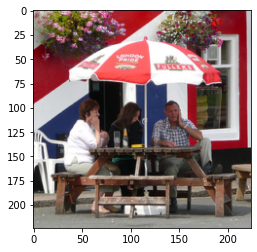

In [29]:
"""
Given a model, a set of raw data and extracted features and an index i,
Print the model's generated caption for the ith image, then print the 5 target
captions. Then print the image.

For the SimpleCaptionGenerator model
"""
def show_img_and_pred1(model, i, raw_data, data_features):
    plt.imshow(raw_data[i][0].permute(1, 2, 0))
    print_pred(predict1(model, data_features[i][0], 0, 15), Vocab)
    print()
    for cap in data_features[i][1]:
        print_pred(cap, Vocab)

show_img_and_pred1(m, 93, test_data, test_data_features)

In [33]:
# Find the number of trainable parameters of the transformer model
for name, param in model4.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

embed.weight torch.Size([8781, 64])
src_embed2.weight torch.Size([64, 256])
src_embed2.bias torch.Size([64])
src_embed.weight torch.Size([256, 512])
src_embed.bias torch.Size([256])
trans.encoder.layers.0.self_attn.in_proj_weight torch.Size([192, 64])
trans.encoder.layers.0.self_attn.in_proj_bias torch.Size([192])
trans.encoder.layers.0.self_attn.out_proj.weight torch.Size([64, 64])
trans.encoder.layers.0.self_attn.out_proj.bias torch.Size([64])
trans.encoder.layers.0.linear1.weight torch.Size([512, 64])
trans.encoder.layers.0.linear1.bias torch.Size([512])
trans.encoder.layers.0.linear2.weight torch.Size([64, 512])
trans.encoder.layers.0.linear2.bias torch.Size([64])
trans.encoder.layers.0.norm1.weight torch.Size([64])
trans.encoder.layers.0.norm1.bias torch.Size([64])
trans.encoder.layers.0.norm2.weight torch.Size([64])
trans.encoder.layers.0.norm2.bias torch.Size([64])
trans.encoder.norm.weight torch.Size([64])
trans.encoder.norm.bias torch.Size([64])
trans.decoder.layers.0.self_att

In [34]:
# Find the number of trainable parameters for the SimpleCaptionGenerator model
for name, param in m.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

embed_shared.weight torch.Size([100, 512])
embed_shared.bias torch.Size([100])
embed1.weight torch.Size([1000, 4900])
embed1.bias torch.Size([1000])
embed2.weight torch.Size([1000, 1000])
embed2.bias torch.Size([1000])
embed3.weight torch.Size([256, 1000])
embed3.bias torch.Size([256])
word_embed.weight torch.Size([8781, 100])
rnn.weight_ih_l0 torch.Size([768, 100])
rnn.weight_hh_l0 torch.Size([768, 256])
rnn.bias_ih_l0 torch.Size([768])
rnn.bias_hh_l0 torch.Size([768])
proj.weight torch.Size([8781, 256])
proj.bias torch.Size([8781])
batch_norm1.weight torch.Size([100])
batch_norm1.bias torch.Size([100])
batch_norm2.weight torch.Size([1000])
batch_norm2.bias torch.Size([1000])
batch_norm3.weight torch.Size([1000])
batch_norm3.bias torch.Size([1000])
batch_norm4.weight torch.Size([256])
batch_norm4.bias torch.Size([256])
batch_norm5.weight torch.Size([100])
batch_norm5.bias torch.Size([100])
